LDA Accuracy = 97.0
QDA Accuracy = 95.0


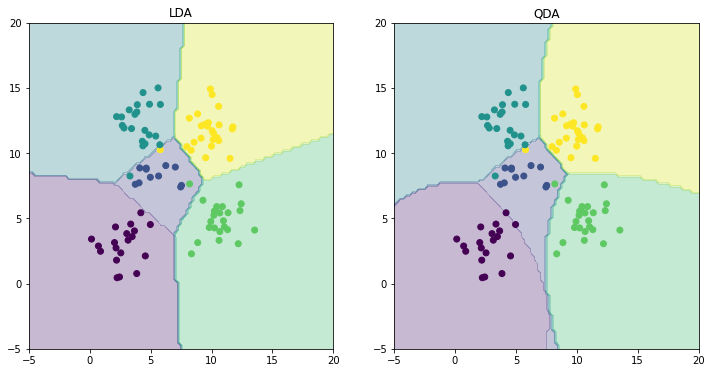

MSE without intercept [106775.36145124]
MSE with intercept [3707.84018096]
(0.0, array([2187.16029493]), array([3707.84018177]))
(0.01, array([2306.83221793]), array([2982.44611971]))
(0.02, array([2354.07134393]), array([2900.97358708]))
(0.03, array([2386.7801631]), array([2870.94158888]))
(0.04, array([2412.119043]), array([2858.00040957]))
(0.05, array([2433.1744367]), array([2852.66573517]))
(0.06, array([2451.52849064]), array([2851.33021344]))
(0.07, array([2468.07755253]), array([2852.34999406]))
(0.08, array([2483.36564653]), array([2854.87973918]))
(0.09, array([2497.74025857]), array([2858.44442115]))
(0.1, array([2511.43228199]), array([2862.75794143]))
(0.11, array([2524.60003852]), array([2867.63790917]))
(0.12, array([2537.35489985]), array([2872.96228271]))
(0.13, array([2549.77688678]), array([2878.64586939]))
(0.14, array([2561.92452773]), array([2884.62691417]))
(0.15, array([2573.84128774]), array([2890.85910969]))
(0.16, array([2585.55987497]), array([2897.30665895

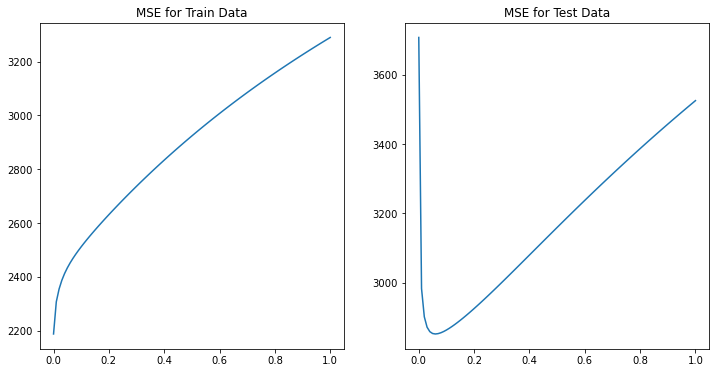

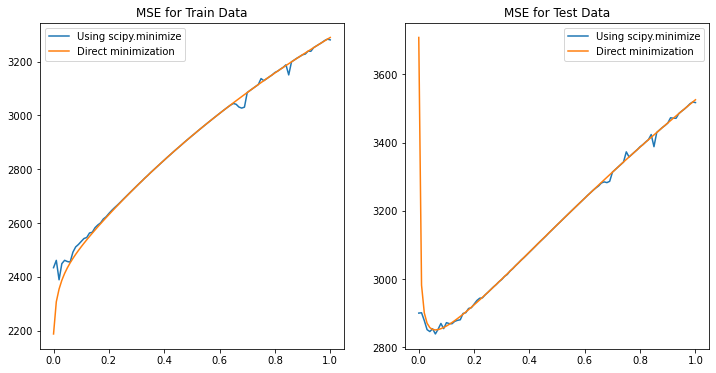

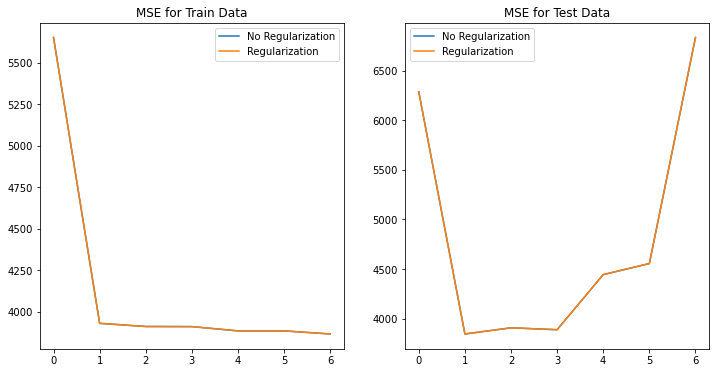

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys

def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    
    # IMPLEMENT THIS METHOD 
    mset={e for l in y for e in l}
    mset=set()
    for l in y:
        for e in l:
            mset.add(int(e))
    a=list(mset)
    means = np.zeros((2,5))
    covmat = np.zeros((2,2))
    i=1
    while i<6:
        means[:, i-1] = np.mean(X[np.where(y==i)[0],:], axis=0).transpose()
        i=i+1
    covmat = np.cov(X.T)
    return means,covmat

def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD
    mset={e for l in y for e in l}
    mset=set()
    for l in y:
        for e in l:
            mset.add(int(e))
    a=list(mset)
    means = np.zeros((2, 5))
    covmats = []
    i=1
    while i<6:
        means[:, i-1] = np.mean(X[np.where(y==i)[0],:], axis=0).transpose()
        bc=X[np.where(y==i)[0],:]
        covmats.append(np.cov(np.transpose(bc)))
        i=i+1
    return means,covmats

def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    ypred = np.empty((np.shape(Xtest)[0], 1))
    mistake = 0
    invCov = np.linalg.inv(covmat)
    ytest = ytest.astype(int)
    i=1
    while i<(np.shape(Xtest)[0] + 1):
        testX = np.transpose(Xtest[i-1,:])
        class_predicted = 0
        r = 0
        j=1
        while j<(np.shape(means)[1]+1):
            r_obtained = np.exp((-1/2)*np.dot(np.dot(np.transpose(testX - means[:, j-1]),invCov),(testX - means[:, j-1])))
            if (r_obtained > r):
                ypred[i-1,:] = j
                class_predicted = j
                r = r_obtained
            j=j+1
        if (class_predicted != ytest[i-1]):
            mistake+=1
        i=i+1
    acc = ((np.shape(Xtest)[0] - mistake)/np.shape(Xtest)[0]) *100
    return acc,ypred

def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    p = np.shape(means)[1]
    d = np.shape(Xtest)[1]
    temp = np.empty((np.shape(Xtest)[0],p))
    class_predicted = np.empty((np.shape(Xtest)[0],1))
    mistake = 0
    covmat_array = np.array(covmats)
    for i in range(0,p):
        j=0
        while j<(np.shape(Xtest)[0]):
            p = np.dot(np.dot(Xtest[j,:]-np.transpose(means[:,i]),np.linalg.inv(covmat_array[i])),(Xtest[j,:]-np.transpose(means[:,i])))
            temp[j,i] = 1/(2*pi)*np.sqrt(np.linalg.det(covmat_array[i])) * np.exp(p)
            j=j+1
    class_predicted = (np.argmin(temp,axis=1)) 
    class_predicted+=1
    i=0
    while i<(np.shape(Xtest)[0]):
        if(ytest[i] != class_predicted[i]):
            mistake+=1
        i=i+1
    ypred = class_predicted.reshape(Xtest.shape[0],1)
    all=np.shape(Xtest)[0]
    acc = ((all-mistake)/all)*100
    return acc,ypred

def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
	
    # IMPLEMENT THIS METHOD   
    w = np.dot(np.linalg.pinv(X), y)
    return w

def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                

    # IMPLEMENT THIS METHOD    
    c=X.shape[1]
    w = np.linalg.inv(np.dot(X.T, X) + (lambd * np.eye(c)))
    w = np.dot(np.dot(w, X.T), y)
    return w

def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse
    y_obtained = np.dot(Xtest, w)
    f=Xtest.shape[0]
    mse = np.sum(((ytest - y_obtained) * (ytest - y_obtained)), axis = 0) 
    mse=mse/f 
    # IMPLEMENT THIS METHOD
    return mse

def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  

    # IMPLEMENT THIS METHOD
    w = w.reshape(65,1)
    error = 0.5 * np.dot((np.dot(X,w) - y).T, (np.dot(X,w) - y)) + 0.5 * lambd * np.dot(w.T, w)
    error_grad = (np.dot(np.dot(X.T, X), w) - np.dot(X.T, y) + lambd * w).flatten()
    return error, error_grad

def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
	
    # IMPLEMENT THIS METHOD
    kik = x.shape[0]
    Xp = np.ones((kik, p+1))
    i=1
    while i<(p+1):
        Xp[:, i] = x ** i
        i=i+1
    return Xp

# Main script

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

# plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.ravel())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.ravel())
plt.title('QDA')

plt.show()
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
l4=zip(lambdas,mses3_train,mses3)
for i in l4:
    print(i)
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()
# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()


# Problem 5
pmax = 7
lambda_opt = 0 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()

